In [1]:
import networkx as nx
import matplotlib.pyplot as plt

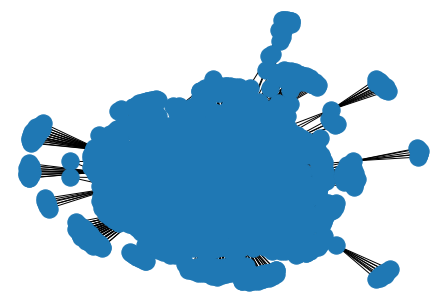

In [4]:
G = nx.read_edgelist("/home/alberto/Documents/GitHub/Learining-From-Networks/Graphs/kw_2.txt")
nx.draw(G)
plt.show()

In [5]:
#compute some centralities
degree_centralities = nx.degree_centrality(G)
closeness_centralities = nx.closeness_centrality(G)
betweenness_centralities = nx.betweenness_centrality(G)

#create a matrix with shape [num_nodes, num_node_features]
h, w = G.number_of_nodes(), 3
nodes_features = [[0 for x in range(w)] for y in range(h)]
for i in range(G.number_of_nodes()):
    nodes_features[i][0] = list(degree_centralities.values())[i]
    nodes_features[i][1] = list(closeness_centralities.values())[i]
    nodes_features[i][2] = list(betweenness_centralities.values())[i]

In [6]:
import torch
from torch_geometric.data import Data
